# 1.  Construir un programa que simule un sistema de colas con un solo servidor con dos colas.
Una de ellas con prioridad. Entregar el código fuente con los comentarios necesarios para explicar el proceso. El programa debe al menos entregar datos de espera promedio para los usuarios de cada cola.

In [ ]:
#@title Solution

!pip install simpy==4.0.1

from operator import attrgetter, add

import numpy as np
import pandas as pd
import scipy.stats as st
import simpy
from tqdm import tqdm


class System(object):
    def __init__(self, env, num_servers, num_queues, arrival_time, policy):
        self.env = env
        self.queues = Queues(num_queues, arrival_time)
        self.servers = Servers(num_servers)
        self.policy = getPolicy(policy)
        self.actual_queue = None
        self.min_queue = None
        self.max_queue = None

    def Simulation(self):
        # Generates customers for the queues
        for queue in self.queues.queues:
            self.env.process(queue.generateCustomer(self.env))
        scheduler = self.policy
        while True:
            # saves the actual queue with less customers
            self.min_queue = min(self.queues.queues, key=attrgetter('maxLen'))
            # saves the actual queue with more customers
            self.max_queue = max(self.queues.queues, key=attrgetter('maxLen'))
            # selects the queue with more customers to work with it
            self.actual_queue = self.max_queue
            # check if there are customers in queue and server available
            if len(self.actual_queue.customers) and len(self.servers.availableServers):
                # get customer based on policy
                customer = scheduler(self.actual_queue)
                # send customer to server
                self.env.process(self.servers.ServeCustomer(self.env, customer, self.actual_queue))
            yield self.env.timeout(0.1)


def serverStats(availableServers, totalTime=4800, num_servers=5):
    total_service_time = 0
    avg_busy_time = 0
    for server in availableServers:
        avg_busy_time += server.TotalServiceTime / totalTime
    return avg_busy_time / num_servers


def customerStat(queue):
    all_customers = queue.customerServerd
    arrival_time = []
    time_spent = []
    numOfSatisfied = 0
    for customer in all_customers:
        arrival_time.append(customer.interarrival_time)
        time_spent.append(customer.timeSpent)
        if (customer.num_of_services == 1):
            numOfSatisfied += 1

    return arrival_time, time_spent, numOfSatisfied


def saveSystemStat(dic, system):
    arrival_time, timeSpent, satisfiedCustomer = customerStat(system.queues.merged_queues_stats)
    dic["numCustomer"].append(len(timeSpent))

    # Time stats
    dic["totalTimeInSys"].append(sum(timeSpent) / len(timeSpent))
    dic["maxTimeInSys"].append(max(timeSpent))

    # total num of satisfied customer
    dic["numSatisfied"].append(satisfiedCustomer)
    # queue stats
    dic["avgQueueLen"].append(sum([len(queue.numCustomer) for queue in system.queues.queues]) / len(system.queues.queues))
    dic["maxQueueLen"].append(sum([queue.maxLen for queue in system.queues.queues]) / len(system.queues.queues))

    # average server busy time
    dic["meanBusyTime"].append(serverStats(system.servers.availableServers, num_servers = num_servers))

    # max number of busy server
    dic["maxBusyServer"].append(sum([queue.maxNumBusyServer for queue in system.queues.queues]) / len(system.queues.queues))

def queues_stats():
    for queue in system.queues.queues:
        print("customers_server:", queue.customerServerd)
        print("customers:", queue.customers)

def showSystemStats(dic):
    variables = dic.keys()
    dataframe = {"variables": [], "mean": [], "stander deviation": [], "confidence interval 95%": []}
    for variable in list(variables):
        # obtains more complex metrics using numpy
        mean, std, confidenceInterval = variableStats(dic[variable])
        dataframe["variables"].append(variable)
        dataframe["mean"].append(mean)
        dataframe["stander deviation"].append(std)
        dataframe["confidence interval 95%"].append(confidenceInterval)
    dataframe = pd.DataFrame(dataframe)
    dataframe.set_index("variables")
    pd.set_option('display.max_columns', None)
    print(dataframe)


def variableStats(list_):
    mean = np.mean(list_)
    std = np.std(list_)
    confidenceInterval = st.t.interval(0.95, len(list_) - 1, loc=np.mean(list_), scale=st.sem(list_))

    return mean, std, confidenceInterval


def priority_(queue):
    queue.customers = sorted(queue.customers, key=lambda customer: customer.num_of_services, reverse=True)
    return queue.customers.pop(0)


def FIFO(queue):
    return queue.customers.pop(0)


def getPolicy(policy):
    if policy == "FIFO":
        return FIFO

    elif policy == "Priority":
        return priority_


class Customer():
    def __init__(self):
        self.num_of_services = 0
        self.a = 2
        self.b = 2.8
        self.serviceTime = []
        self.timeSpent = 0
        self.arrival_timeStamp = 0
        self.interarrival_time = 0

    def calculateServiceTime(self):
        a = (self.a) / (1 + self.num_of_services)
        b = (self.b) / (1 + self.num_of_services)
        serviceTime = np.random.uniform(a, b)
        return serviceTime


class Queue():
    def __init__(self, meanArrivalTime=5):
        self.customers = []
        self.maxLen = 0
        self.customerServerd = []
        self.available = 1
        self.maxNumBusyServer = 0
        self.numCustomer = []
        self.meanArrivalTime = meanArrivalTime

    def updateMaxLen(self):
        if (len(self.customers) > self.maxLen):
            self.maxLen = len(self.customers)

    def generateCustomer(self, env):
        id = 0
        while (self.available):
            arrival_time = np.random.exponential(self.meanArrivalTime)
            yield env.timeout(arrival_time)
            c = Customer()
            c.arrival_timeStamp = env.now
            c.interarrival_time = arrival_time
            c.id = id
            id += 1
            self.customers.append(c)
            if (len(self.customers) > self.maxLen):
                self.maxLen = len(self.customers)
            self.numCustomer += [len(self.customers)]

        return 0


class Queues():
    def __init__(self, num_queues, arrival_time):
        self.queues = [Queue(arrival_time) for queue in range(num_queues)]

    @property
    def merged_queues_stats(self):
        merged_queue = Queue()
        for queue in self.queues:
            merged_queue.customers = merged_queue.customers + queue.customers
            merged_queue.maxLen = merged_queue.maxLen + queue.maxLen
            merged_queue.customerServerd = merged_queue.customerServerd + queue.customerServerd
            merged_queue.maxNumBusyServer = merged_queue.maxNumBusyServer + queue.maxNumBusyServer
            merged_queue.numCustomer = merged_queue.numCustomer + queue.numCustomer
        return merged_queue


class Server():
    def __init__(self):
        self.TotalServiceTime = 0
        self.numCustomer = 0


class Servers():
    def __init__(self, num_servers=1):
        self.availableServers = [Server() for i in range(num_servers)]
        self.num_servers = num_servers

    # server customer using one of the servers available
    def ServeCustomer(self, env, customer, queue):
        server = self.availableServers.pop(0)
        if ((self.num_servers - len(self.availableServers)) > queue.maxNumBusyServer):
            queue.maxNumBusyServer = self.num_servers - len(self.availableServers)
        serviceTime = customer.calculateServiceTime()
        customer.serviceTime.append(serviceTime)
        server.TotalServiceTime += serviceTime
        server.numCustomer += 1
        yield env.timeout(serviceTime)
        # release server
        self.availableServers.append(server)
        # check if customer is satisfied
        choices = [0, 1]
        p = 0.2 / (1 + customer.num_of_services)
        probabilities = [p, 1 - p]
        satisfied = np.random.choice(choices, 1, p=probabilities)
        customer.num_of_services += 1
        if not satisfied:
            customer.timeSpent += serviceTime
            queue.customers.append(customer)
            if (len(queue.customers) > queue.maxLen):
                queue.maxLen = len(queue.customers)
        else:
            customerArrivalTime = customer.arrival_timeStamp
            timeNow = env.now
            customer.timeSpent = timeNow - customerArrivalTime
            queue.customerServerd.append(customer)
        return 0


iteration = n = 200
num_servers = 1
num_queues = 2
arrival_time = 5
policy = "Priority"     # Priority or FIFO
print("num of Servers in the system =", num_servers)
print("num of Queues in the system =", num_queues, f"({policy})")
print("customer mean arrival =", arrival_time)

# evaluation data format
dic = {"numSatisfied": [],
        "totalTimeInSys": [],
        "numCustomer": [],
        "maxTimeInSys": [],
        "avgQueueLen": [],
        "maxQueueLen": [],
        "meanBusyTime": [],
        "maxBusyServer": []}

# tqdm() shows a load bar. Repeats the simulation n times.
for i in tqdm(range(n)):
    # Creates a simpy environment
    env = simpy.Environment()
    # Creates the queues and servers symstem
    system = System(env, num_servers, num_queues, arrival_time, policy)
    # Defines the simulation step proccess
    env.process(system.Simulation())
    # Runs a fixed number of simulation steps (4800 in this case)
    env.run(until=4800)

    # Saves the resulting data for this simulation
    saveSystemStat(dic, system)

print("\n")
# Show general statistics for the n simulations with standar deviation
showSystemStats(dic)

#queues_stats()

# turn the dict data to dataframe
df = pd.DataFrame.from_dict(dic)
# shows the dataframe
df

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
num of Servers in the system = 1
num of Queues in the system = 2 (Priority)
customer mean arrival = 5


100%|██████████| 200/200 [01:44<00:00,  1.92it/s]



        variables         mean  stander deviation  \
0    numSatisfied  1399.110000          23.862688   
1  totalTimeInSys   232.868514          47.540212   
2     numCustomer  1751.235000          12.555866   
3    maxTimeInSys   512.778194          85.964803   
4     avgQueueLen   961.132500          19.316669   
5     maxQueueLen    94.445000          16.954114   
6    meanBusyTime     0.000000           0.000000   
7   maxBusyServer     1.000000           0.000000   

                    confidence interval 95%  
0  (1395.7742755122347, 1402.4457244877651)  
1  (226.22294858618773, 239.51407881521544)  
2  (1749.4798369008652, 1752.9901630991346)  
3   (500.76132126495185, 524.7950674706987)  
4     (958.4322558386681, 963.832744161332)  
5    (92.07501336928853, 96.81498663071146)  
6                                (nan, nan)  
7                                (nan, nan)  



/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2128: RuntimeWarning: invalid value encountered in multiply
  lower_bound = _a * scale + loc
/usr/local/lib/python3.7/dist-packages/scipy/stats/_distn_infrastructure.py:2129: RuntimeWarning: invalid value encountered in multiply
  upper_bound = _b * scale + loc


,numSatisfied,totalTimeInSys,numCustomer,maxTimeInSys,avgQueueLen,maxQueueLen,meanBusyTime,maxBusyServer
0,1358,186.888952,1740,504.189729,967.5,102.5,0.0,1.0
1,1384,271.948829,1752,600.687125,981.0,113.5,0.0,1.0
2,1363,249.403673,1737,613.384872,963.0,105.0,0.0,1.0
3,1410,193.506490,1764,386.803512,944.0,74.0,0.0,1.0
4,1401,268.942776,1738,574.605280,967.5,102.5,0.0,1.0
...,...,...,...,...,...,...,...,...
195,1387,230.515077,1745,464.493774,956.5,89.0,0.0,1.0
196,1358,288.630485,1738,621.759452,983.5,120.0,0.0,1.0
197,1418,160.761290,1760,371.812718,925.0,63.0,0.0,1.0
198,1378,232.864132,1746,467.011966,962.5,90.5,0.0,1.0


# 2. Realizar los incisos a y b del ejercicio 16.5-8 del Libro de Hillier y Lieberman. 
Después de esto, construya un programa que simule ese sistema de inventarios usando el enfoque de eventos discretos. Idee una manera de calcular el costo promedio de inventario y de incumplimiento a largo plazo.

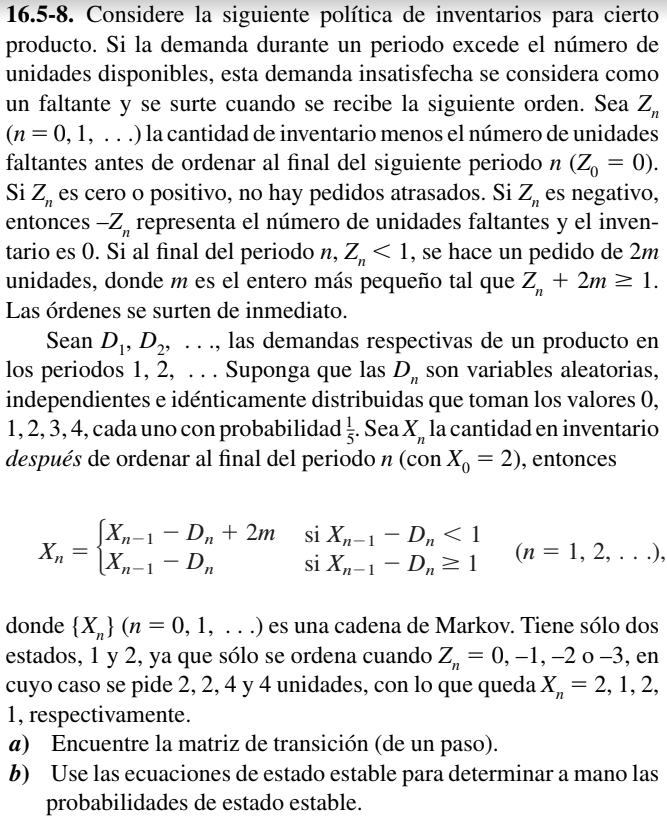

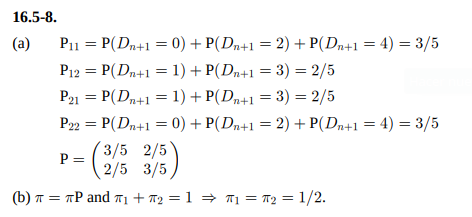

In [ ]:
import random
import simpy
import math

#D = demanda
#CI = cant de inventario
#Q = unidades disponibles
#z = cantidad de inventario antes de ordenar al final del siguiente periodo
#NUF = numero de unidades faltantes
#n = periodo
#m = entero más pequeño
#x = cantidad de inventario después de ordenar al final del periodo n

mu =100
sigma=10
z=0
n = int(input("Ingresa la cantidad de periodos: "))
Q=100
while i in range(n):
  if D>Q:
    CI=Q
    D = int(random.gaus(mu, sigma))
    z=CI-NUF
    if z>=0:
      print(No hay pedidos atrasados)
    else:
      NUF = -z
      inventario=0
    if z<1:
     z+2m>=1
    else:
    x=2
    if 




# 3. Dado un programa que simule un proceso con eventos discretos:

- ¿Qué mecanismos podría utilizar para validar los promedios obtenidos de las variables de interés? Explicar de manera general el proceso. 
- ¿Que mecanismos podría usar para validar que un conjunto de datos aleatorios continuos se comporta como un distribución dada? Explicar también de manera general este proceso.

#### SOLUCIÓN

- Para validar los promedios obtenidos en las variables de interés puede utilizarse la repetición de la simulación múltiples veces para luego guardar todos los promedios obtenidos de cada repetición de la simulación para cada variable de interés para luego hacer un nuevo promedio con los resultados de los experimentos, evitando así posibles problemas de resultados anormales por el comportamiento probabilístio que tienen las simulaciones y validando que los resultados normales son similares entre repeticiones o por lo menos muestran un comportamiento similar.

- Se pueden utilizar múltiples métodos, entre ellos: Correlación de Pearson, Correlación de rango de Spearman y regresiones. La forma en que se calculan estos índices es por medio de la comparación entre los datos obtenidos y que se esperan evaluar contra un resultado esperado que sería en este caso datos que se conoce con anterioridad que siguen correctamente la distribución que se espera. 

# 4. Modificar un ejemplo de implementación del muestreo de Gibbs 

(por ejemplo el que se encuentra en https://mr-easy.github.io/2020-05-21-implementing-gibbs-sampling-in-python/) para que genere
muestras de una distribución que consista en la multiplicación de dos exponenciales con una tasa λ (pueden poner un valor específico). ¿Qué otra forma existe para generar muestras de una distribución así?


In [ ]:
#@title Parte Gauss
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import elipse
import matplotlib.transformadaorms as transformadaorms

def plot_gaussian_from_points(x, y, ax, n_std=3.0, facecolor='none', **kwargs):
   
    if len(x) != len(y):
        raise ValueError("x and y must be the same size")
    if len(x) < 2:
        raise ValueError("Need more data.")
    cov = np.cov(x, y)
    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    radio_x_elipse = np.sqrt(1 + pearson)
    radio_y_elipse = np.sqrt(1 - pearson)
    elipse = elipse((0, 0),
        ancho=radio_x_elipse * 2,
        altura=radio_y_elipse * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    escala_x = np.sqrt(cov[0, 0]) * n_std
    media_x = np.mean(x)

    # calculating the stdandard deviation of y ...
    escala_y = np.sqrt(cov[1, 1]) * n_std
    media_y = np.mean(y)

    transformada = transformadaorms.Affine2D() \
        .rotate_deg(45) \
        .scale(escala_x, escala_y) \
        .translate(media_x, media_y)

    elipse.set_transformadaorm(transformada + ax.transData)
    return ax.add_patch(elipse)
#funcion para crear la gaussiana con parametros
def plot_gaussian_from_parameters(mean, cov, ax, n_std=3.0, facecolor='none', **kwargs):

    if len(mean) != 2:
        raise ValueError("Mean vector length should be 2.")
    if (cov.shape != (2, 2)):
    	raise ValueError("Covariance should be a 2x2 matrix.")
    #checking if cov is symmetric pos semidefinite
    if(cov[0, 1] != cov[1, 0]):
        raise ValueError("Covariance should be symmetric.")
    if(cov[0, 0] < 0 or cov[0, 0]*cov[1,1] - cov[0,1]**2 < 0):
        raise ValueError("Covariance should be positive semidefinite.")

    pearson = cov[0, 1]/np.sqrt(cov[0, 0] * cov[1, 1])
    # Using a special case to obtain the eigenvalues of this
    # two-dimensionl dataset.
    radio_x_elipse = np.sqrt(1 + pearson)
    radio_y_elipse = np.sqrt(1 - pearson)
    elipse = elipse((0, 0),
        ancho=radio_x_elipse * 2,
        altura=radio_y_elipse * 2,
        facecolor=facecolor,
        **kwargs)

    # Calculating the stdandard deviation of x from
    # the squareroot of the variance and multiplying
    # with the given number of standard deviations.
    escala_x = np.sqrt(cov[0, 0]) * n_std
    media_x = mean[0]

    # calculating the stdandard deviation of y ...
    escala_y = np.sqrt(cov[1, 1]) * n_std
    media_y = mean[1]

    transformada = transformadaorms.Affine2D() \
        .rotate_deg(45) \
        .scale(escala_x, escala_y) \
        .translate(media_x, media_y)

    elipse.set_transformadaorm(transformada + ax.transData)
    return ax.add_patch(elipse)


# from random import random

# x = np.array([random()*5 for i in range(500)])
# y = np.array([random()*5 for i in range(500)])
# fig = plt.figure()
# ax = fig.add_axes([0,0,1,1])
# ax.scatter(x, y)
# print(plot_gaussian_from_points(x, y, ax, n_std=1, edgecolor='red'))
# #print(plot_gaussian_from_parameters(np.array([2.5, 2.5]), np.cov(x, y), ax, n_std=1, edgecolor='red'))
# plt.show()    

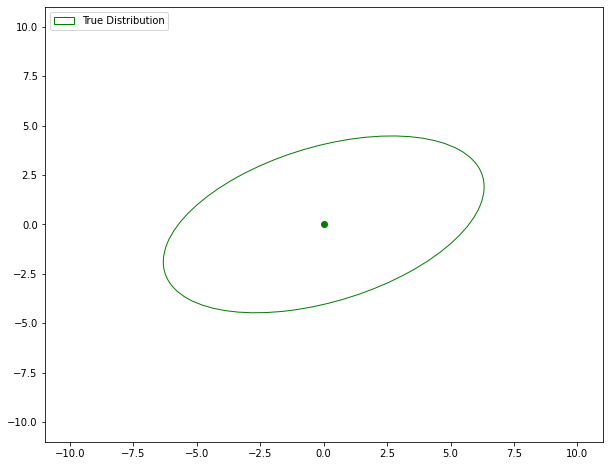

In [ ]:
#Importaciones Necesarias para el funcionamiento del Codigo
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import Image
from random import random


#Creamos el Condicional para su funcionamiento

def conditional_sampler(sampling_index, current_x, mean, cov):
    conditioned_index = 1 - sampling_index
    m = cov[sampling_index, sampling_index]
    n = cov[sampling_index, conditioned_index]
    o = cov[conditioned_index, conditioned_index]
    
    mu = mean[sampling_index] + (b * (current_x[conditioned_index] - mean[conditioned_index]))/c
    sigma = np.sqrt(a-(b**2)/c)
    nueva_x = np.copy(current_x)
    nueva_x[sampling_index] = np.random.randn()*sigma + mu
    return nueva_x
#Creacion de los samples
def plot_samples(samples, num_samples, tmp_points, num_tmp, title="Gibbs Sampling", xlims=(-11, 11), ylims=(-11, 11)):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.gca()
    
    # Plot the true distribution
    plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', alpha=0.5, label="True Distribution")
    
    # Plot sampled points
    ax.scatter(samples[:num_samples, 0], samples[:num_samples, 1], c='b', s=10, label="Sampled Points")
    ax.scatter(samples[0, 0], samples[0, 1], marker='*', c='g', s=60, label="Initial Point")
    
    # Plot samples from conditional distribution
    ax.scatter(tmp_points[:num_tmp, 0], tmp_points[:num_tmp, 1], c='r', alpha=0.4, s=5, label="Temporary Points")
    
    # Keeping the axes scales same for good GIFS
    ax.set_xlim(xlims)
    ax.set_ylim(ylims)
    
    # Plot lines
    if(num_tmp > 0):
        ax.plot([samples[num_samples-1, 0], tmp_points[num_tmp-1, 0]], 
                [samples[num_samples-1, 1], tmp_points[num_tmp-1, 1]], c='k', alpha=0.25)
        # Plot estimated Gaussian, ignoring the starting point
        if(num_samples > 2):
            plot_gaussian_from_points(samples[1:num_samples, 0], samples[1:num_samples, 1],ax, n_std=2, edgecolor='b', alpha=0.5, label="Estimated Distribution")
    
    ax.legend(loc='upper left')
    ax.set_title(title)
#Funcion de gibbs
def gibbs_sampler(initial_point, num_samples, mean, cov, create_gif=True):

    frames = []  # for GIF
    point = np.array(initial_point)
    samples = np.empty([num_samples+1, 2])  #sampled points
    samples[0] = point
    tmp_points = np.empty([num_samples, 2]) #inbetween points

    for i in range(num_samples):

        # Sample from p(x_0|x_1)
        point = conditional_sampler(0, point, mean, cov)
        tmp_points[i] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+1, tmp_points, i+1, title="Num Samples: " + str(i)))
            
        # Sample from p(x_1|x_0)
        point = conditional_sampler(1, point, mean, cov)
        samples[i+1] = point
        if(create_gif):
            frames.append(plot_samples(samples, i+2, tmp_points, i+1, title="Num Samples: " + str(i+1)))
            
    if(create_gif):
        return samples, tmp_points, frames
    else:
        return samples, tmp_points

mean = np.array([0, 0])
cov = np.array([[10, 3], [3, 5]])
# Plot true distribution
fig = plt.figure(figsize=(10, 8))
ax = fig.gca()

plot_gaussian_from_parameters(mean, cov, ax, n_std=2, edgecolor='g', label="True Distribution")
ax.scatter(mean[0], mean[1], c='g')
ax.set_xlim((-11, 11))
ax.set_ylim((-11, 11))
ax.legend(loc='upper left')
plt.show()